In [33]:
import os, importlib, sys, time

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
import scipy.linalg as la
import scipy.stats as stats

In [36]:
import pyarrow

# 1. parameters

In [37]:
T = 60
T0 = 40

In [38]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [39]:
pi = np.zeros(T+T0)
pi[:min(GPi['pi'].shape[0], T+T0)] = GPi['pi'][:min(GPi['pi'].shape[0], T+T0)]
alpha = 0.01
r_Y = 10

<BarContainer object of 70 artists>

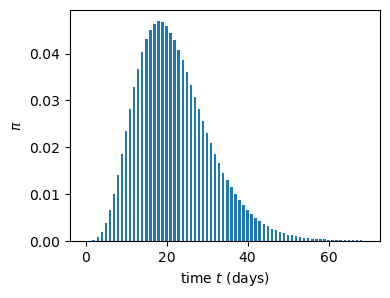

In [40]:
plt.figure(figsize = (4,3))
plt.xlabel("time $t$ (days)"); plt.ylabel("$\pi$")
plt.bar(np.arange(70), pi[:70], width=0.6)

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [41]:
g = np.zeros(T+T0)
g[:min(GPi['g'].shape[0], T+T0)] = GPi['g'][:min(GPi['g'].shape[0], T+T0)]

<BarContainer object of 70 artists>

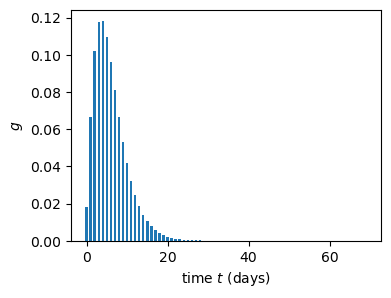

In [42]:
plt.figure(figsize = (4,3))
plt.xlabel("time $t$ (days)"); plt.ylabel("$g$")
plt.bar(np.arange(70), g[:70], width=0.6)

In [43]:
d = 2
beta = np.array([0, -2.2])

In [44]:
r_I = 100
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

In [45]:
mu = np.log(100)

$$I_{-T_0} = \mu_0$$

# 2. simulation

In [46]:
num_sim = 1000

## random seed

In [47]:
np.random.seed(1234)

## data generation

In [48]:
I0 = np.full(T0, np.exp(mu))

In [49]:
A = np.stack([np.full(T, 1), 1 * (np.arange(T) > 15)], -1)
R = K / (1 + np.exp(- A @ beta))

In [50]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, np.arange(T)[:,None] - np.arange(T))]
Pi0 = alpha * np.concatenate([[0],pi])[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))]

In [51]:
G = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T)[:,None] - np.arange(T))]
G0 = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))]

In [52]:
inv_ImG = la.inv(np.eye(T) - G)

In [53]:
EEI = inv_ImG @ (G0 @ I0)

In [54]:
EI = np.zeros((num_sim, T))
I = np.zeros((num_sim, T))

In [55]:
for t in np.arange(T):
    EI[:,t] = G0[t] @ I0 + G[t,:t] @ I[:,:t].T
    I[:,t] = np.random.negative_binomial(r_I, r_I/(r_I+EI[:,t]))

In [56]:
EEY = EEI @ Pi.T + Pi0 @ I0

In [57]:
EY = I @ Pi.T + Pi0 @ I0
Y = np.random.negative_binomial(r_Y, r_Y/(r_Y+EY))

## result

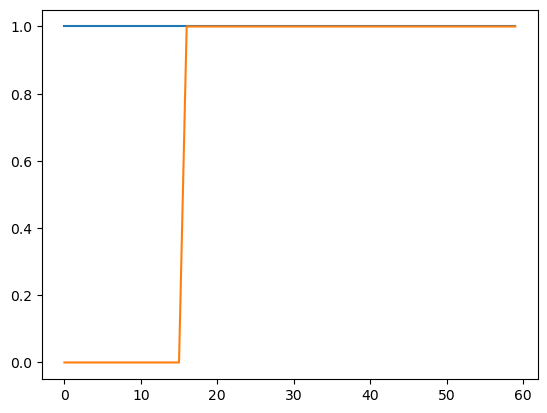

In [58]:
plt.plot(A)

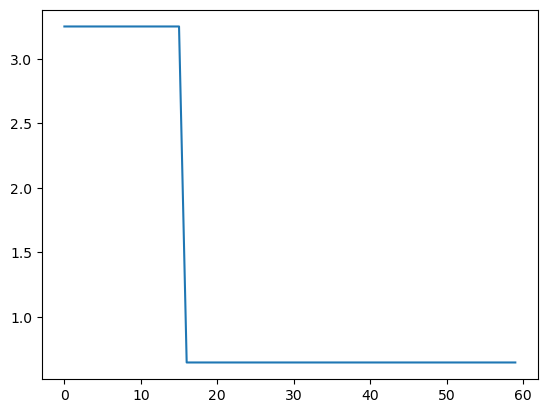

In [59]:
plt.plot(R)

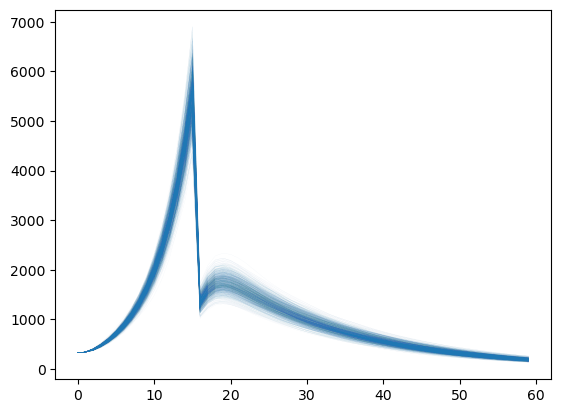

In [81]:
plt.plot(EI.T, color='C0', alpha=0.1, linewidth=0.1)
plt.show()

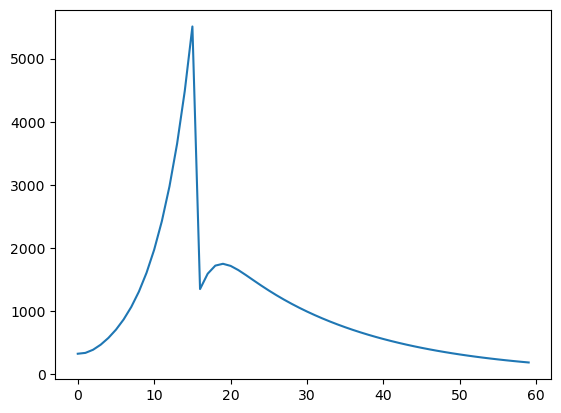

In [82]:
plt.plot(EEI)
plt.show()

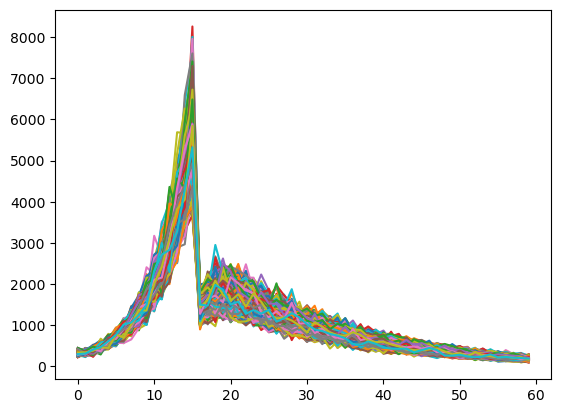

In [62]:
plt.plot(I.T)
plt.show()

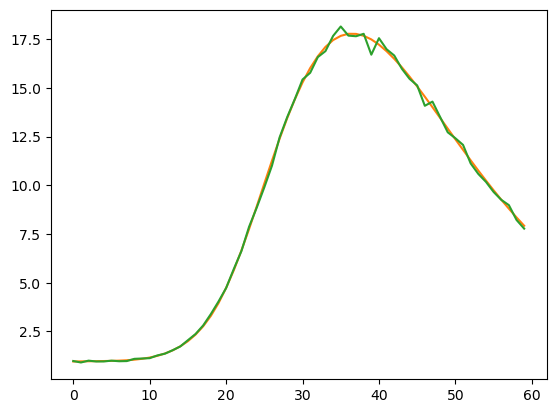

In [63]:
plt.plot(np.mean(EEY, 0))
plt.plot(np.mean(EY, 0))
plt.plot(np.mean(Y, 0))
plt.show()

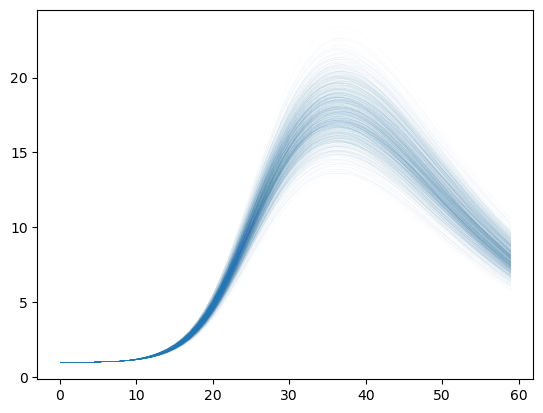

In [83]:
plt.plot(EY.T, color='C0', alpha=0.1, linewidth=0.1)
plt.show()

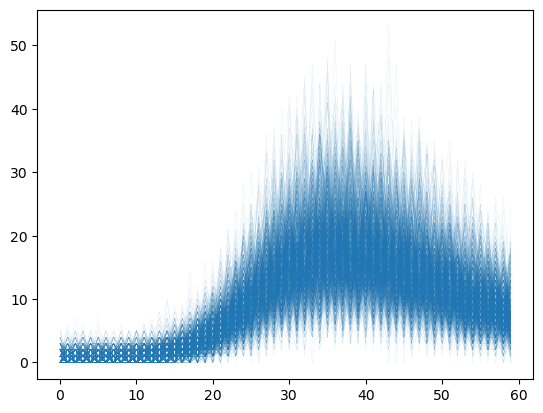

In [78]:
plt.plot(Y.T, alpha=0.3, linewidth=0.1, color='C0')
plt.show()

# 3. Save Data

In [32]:
data = {'sim': np.tile(np.arange(num_sim)[:,None], (1,T)).flatten(),
        'date': np.tile(np.arange(T), (num_sim,1)).flatten(),
        'R': np.tile(R, (num_sim,1)).flatten(),
        'EI': EI.flatten(),
        'infection': I.flatten(),
        'EY': EY.flatten(),
        'death': Y.flatten(),
        'intervention': np.tile(A[:,1], (num_sim,1)).flatten()}

In [33]:
df = pd.DataFrame(data)

In [34]:
df

,sim,date,R,EI,infection,EY,death,intervention
0,0,0,3.250000,324.997762,356.0,0.956069,0,0
1,0,1,3.250000,340.245831,298.0,0.962543,0,0
2,0,2,3.250000,392.196621,409.0,0.968283,0,0
3,0,3,3.250000,471.047829,545.0,0.973654,1,0
4,0,4,3.250000,581.900998,584.0,0.979752,4,0
...,...,...,...,...,...,...,...,...
59995,999,55,0.648378,209.251090,218.0,9.330738,18,1
59996,999,56,0.648378,199.304639,232.0,8.838784,8,1
59997,999,57,0.648378,190.393661,212.0,8.368827,7,1
59998,999,58,0.648378,182.315811,204.0,7.916002,3,1


In [35]:
df.to_feather('data/simulation_randinf_0.feather')